In [1]:
# IMPORT PACKAGES FOR SIMULATION 
# for aster counter algorithm
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from itertools import product
from scipy.signal import convolve2d
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import matplotlib.path as pltpath

#jupyter notebook specific import
import time
from tqdm import tqdm
%matplotlib inline
from matplotlib.pyplot import imshow

# for simulation
from PIL import Image, ImageDraw
import numpy as np
from os import path, makedirs
import matplotlib.path as pltpath

# for writing .png's to .tif
import glob
from scipy import misc
from tifffile import imsave

In [2]:
# SIMULATION HEAD 
from PIL import Image, ImageDraw

def sim(J,Z,params,boundary):
    '''simulation function to determine motor
       and filament events'''
    for t in tqdm(range(0,params['time'])):
        # determine myosin motor state
        # myosinII motor state forward 0->1->2
        # myosinII motor state backward 2->1->0
        tempJ = J
        # apply forward change of states on myosin motors
        for j in range(0,params['motors']):
            if tempJ[0,j] != 2:
                tempJ[0,j],tempJ[1,j],tempJ[3,j],tempJ[4,j] = motor_state_forward(j,tempJ,params,boundary);
                if tempJ[0,j] == 2 and tempJ[0,tempJ[1,j].astype(int)] != 2:
                    tempJ[0,tempJ[1,j].astype(int)] = 2
                    tempJ[1,tempJ[1,j].astype(int)] = j

            # move newly paired myosin motor bundles to the same location, halfway between original locations
            if tempJ[0,j] == 2 and J[0,j] != 2 and tempJ[2,j] == -1 and tempJ[2,tempJ[1,j].astype(int)] == -1 and \
               j<tempJ[1,j]:
                    tempJ[3,j] = (tempJ[3,j] + tempJ[3,tempJ[1,j].astype(int)])/2
                    tempJ[4,j] = (tempJ[4,j] + tempJ[4,tempJ[1,j].astype(int)])/2
                    tempJ[3,tempJ[1,j].astype(int)] = tempJ[3,j]
                    tempJ[4,tempJ[1,j].astype(int)] = tempJ[4,j]

        # apply backward change of state on myosin motors
        for j in range(0,params['motors']):
            if tempJ[0,j] == 1 and params['inactivationRate']*params['tstep']>np.random.uniform():
                tempJ[0,j] = 0
            elif tempJ[0,j] == 2 and tempJ[2,j] == -1 and tempJ[2,tempJ[1,j].astype(int)] == -1 and \
            params['unbundleRate']*params['tstep']>np.random.uniform():
                tempJ[0,tempJ[1,j].astype(int)] = 1
                tempJ[1,tempJ[1,j].astype(int)] = -1
                tempJ[0,j] = 1
                tempJ[1,j] = -1

        J = tempJ


        # check if myosin motors attach or detach from filaments
        # call sub-routine if myosin motor is bundled and has not been edited yet
        # i.e. condition will evaluate as false for J[1,j] == -1 (not bundled)
        # and for motor in state 2 with bundled motor index greater than itself (to avoid repeat)
        cands = np.where(J[1,:]>J[1,J[1,:].astype(int)])[0]
        if len(cands>0):
            for j in cands:
                J[2,j],J[2,J[1,j].astype(int)],J[3,j],J[4,j],J[3,J[1,j].astype(int)],J[4,J[1,j].astype(int)] = \
                motor_attach_detach(J[2,j].astype(int),J[2,J[1,j].astype(int)].astype(int),
                                     J[3,j],J[4,j],
                                     J[3,J[1,j].astype(int)],J[4,J[1,j].astype(int)],
                                     Z,params,boundary)


        # determine movement of myosin motors that are bound to filaments
        cands = np.where( ((J[2,:]!=-1) | (J[2,J[1,:].astype(int)]!=-1)) & (J[1,:]>J[1,J[1,:].astype(int)]) )[0]
        for j in cands:
            # call sub-routine if myosin motor is bundled, attached to a filament and has not been edited yet
            J[2,j],J[2,J[1,j].astype(int)],J[3,j],J[4,j],J[3,J[1,j].astype(int)],J[4,J[1,j].astype(int)] = \
            bound_motor_movement(J[2,j].astype(int),J[2,J[1,j].astype(int)].astype(int),
                                  J[3,j],J[4,j],
                                  J[3,J[1,j].astype(int)],J[4,J[1,j].astype(int)],
                                  Z,params)


        # check if any filaments undergo depolymerization
        for f in range(0,params['filaments']):
            # check if filament depolymerizes
            if params['p2']*params['tstep']>np.random.uniform():
                J,Z[0,f],Z[1,f],Z[2,f],Z[3,f],Z[4,f] = depolymerization(J,f,params,boundary)


        # iteratively determine filament movement
        for f in range(0,params['filaments']):
            # determine force and movement on filament
            Z[0,f],Z[1,f],Z[2,f],old_xp,old_yp = force_on_filament(J,Z[0,f],Z[1,f],Z[2,f],Z[3,f],Z[4,f],f,params)
            Z[3,f] = Z[0,f] + params['fil_length']*np.cos(Z[2,f])
            Z[4,f] = Z[1,f] + params['fil_length']*np.sin(Z[2,f])
            # check if filament hit boundaries
            Z[:,f] = filament_boundary_check(Z,f,params,boundary)

            # move motors attached to filament accordingly
            # find motors on filament
            mots1 = np.where(J[2,:]==f)[0]
            # distance between motor and plus end of filament
            s = np.sqrt( (old_xp - J[3,mots1])**2 + (old_yp - J[4,mots1])**2);
            # x and y movement of motor to be on filament
            J[3,mots1] = Z[0,f] + s*np.cos(Z[2,f]);
            J[4,mots1] = Z[1,f] + s*np.sin(Z[2,f]);


        # check if any bundled myosin motors have surpassed stretch radius limit
        # every motor on a filament (group1)
        v1 = np.where(J[2,:]!=-1)[0]
        # bundle index for each myo motor in v1 (group2)
        v2 = J[1,v1].astype(int)
        # bound filament index for v1 myo motors (group3)
        v3 = J[2,v1]
        # bound filament index for v2 myo motors (group4)
        v4 = J[2,v2]
        # myo motors of group4 that are not bound to a filament
        r1 = np.where(v4==-1)[0]
        # myo motor bundles where both legs are bound to same filament
        r2 = np.where(v3==v4)[0]
        # group1 with exclusions (r1 and r2)
        g1 = np.delete(v1,np.union1d(r1,r2))
        # find stretch distances between candidate myosin motors
        motor_stretch = np.sqrt((J[3,g1] - J[3,J[1,g1].astype(int)])**2 + (J[4,g1] - J[4,J[1,g1].astype(int)])**2)
        # find indices of stretch that surpass bundled myosin stretch limit
        overstretched = np.where(motor_stretch>params['r'])[0]
        # for bundled pairs passing radius, randomly select a leg to unbind from filament and move to other leg's position
        for motor in overstretched:
            mot = g1[motor]
            if np.random.uniform()<0.5:
                J[2,mot] = -1
                J[3,mot] = J[3,J[1,mot].astype(int)]
                J[4,mot] = J[4,J[1,mot].astype(int)]
            else:
                J[2,J[1,mot].astype(int)] = -1
                J[3,J[1,mot].astype(int)] = J[3,mot]
                J[4,J[1,mot].astype(int)] = J[4,mot]

                
        # save positional information
        if params['save_pos_data'] == 1:
            time_point = str(int(((t+1)/params['image_iter'])))
            order = len(str(params['time']))
            lead_zeros = order - len(str(time_point))
            built_name = ''
            for i in range(lead_zeros):
                built_name+='0'
            name = built_name+str(time_point)
            jfile = "./pos_data/jdata_"+name+".txt"
            zfile = "./pos_data/zdata_"+name+".txt"
            np.savetxt(jfile, np.transpose(J))
            np.savetxt(zfile, np.transpose(Z))
        

        # write image data to '.png' file
        if params['save_image']==1:
            if (t+params['image_iter']+1)%params['image_iter'] == 0:
                time_point = str(int(((t+1)/params['image_iter'])))

                order = len(str(params['time']))
                lead_zeros = order - len(str(time_point))
                built_name = ''
                for i in range(lead_zeros):
                    built_name+='0'
                name = params['image_save_path']+params['image_save_name']+built_name+str(time_point)+'.png'

                im_png = Image.fromarray(split_image_build(J,Z,params))
                im_png.save(name)

                
    # finish and pass data back
    return J,Z

In [3]:
# SUB-ROUTINES 
def motor_boundary_check(x,y,params,boundary):
    '''sub-routine to check/evaluate motor
       positions with reflective boundaries'''
    if ~boundary.contains_point(np.array([x,y])):
        h = params['boundary_height'];
        w = params['boundary_width'];
        # determine which boundaries have been passed by motor
        b = [np.less(y,-1*h),np.greater(y,h),np.less(x,-1*w),np.greater(x,w)];
        # b[0] = y position below bottom boundary
        # b[1] = y position above top boundary
        # b[2] = x position left of left boundary
        # b[3] = x position right of right boundary
        if b[0] == True and b[2] == False and b[3] == False:
            y = -1*h;
        elif b[1] == True and b[2] == False and b[3] == False:
            y = h;
        elif b[2] == True and b[0] == False and b[1] == False:
            x = -1*w;
        elif b[3] == True and b[0] == False and b[1] == False:
            x = w;
        elif b[0] == True and b[2] == True:
            x = -1*w;
            y = -1*h;
        elif b[0] == True and b[3] == True:
            x = w;
            y = -1*h;
        elif b[1] == True and b[2] == True:
            x = -1*w;
            y = h;
        elif b[1] == True and b[3] == True:
            x = w;
            y = h;

    return x,y

def motor_state_forward(j,J,params,boundary):
    '''sub-routine for determining forward changes
       in the motor state; if motor state does not
       change, then motor diffuses'''
    # check if motor ungergoes activation event
    if J[0,j] == 0:
        # define state transition
        if params['activationRate']*params['tstep'] > np.random.uniform():
            J[0,j] = 1
        # define motor diffusion movement
        J[3,j] = J[3,j] + np.sqrt(2*params['tstep']*params['diffusionRate'])*np.random.randn()
        J[4,j] = J[4,j] + np.sqrt(2*params['tstep']*params['diffusionRate'])*np.random.randn()
        J[3,j],J[4,j] = motor_boundary_check(J[3,j],J[4,j],params,boundary)


    # check if motor undergoes bundling event
    elif J[0,j] == 1:
        # condition 1: look for motor candidates to bundle with
        candidate1 = np.where(J[0,:] == 1)[0]

        # condition 2: look for motors within motorBundleRadius
        candidate2 = np.where(np.sqrt((J[3,candidate1]-J[3,j])**2 + \
                              (J[4,candidate1]-J[4,j])**2)<params['motorBundleRadius'])[0]

        # group the candidate lists together (returns indices of candidates)
        bundle_candidates = [candidate1[i] for i in candidate2]

        # check the probability of a bundling event
        if (len(bundle_candidates)*params['tstep']*params['bundleRate']>np.random.uniform()
            and len(bundle_candidates)>1):
            # uniformly randomly select a motor to bundle with
            J[1,j] = bundle_candidates[int(np.ceil(len(bundle_candidates)*np.random.uniform()))-1]
            # if motor selected is itself - try again
            while J[1,j]==j:
                J[1,j] = bundle_candidates[int(np.ceil(len(bundle_candidates)*np.random.uniform()))-1]
            # declare motor state as bundled
            J[0,j] = 2
        else:
            # diffusion of motor occurs if no bundling event
            J[3,j] = J[3,j] + np.sqrt(2*params['tstep']*params['diffusionRate'])*np.random.randn()
            J[4,j] = J[4,j] + np.sqrt(2*params['tstep']*params['diffusionRate'])*np.random.randn()
            J[3,j],J[4,j] = motor_boundary_check(J[3,j],J[4,j],params,boundary)

    return J[0,j],J[1,j],J[3,j],J[4,j]

def find_filaments_2D(Z,x,y,r):
    '''called by motor_attach_detach to query for
       candidate actin filaments for a given motor
       to potentially bind to'''
    # evaluate sub-components of generalized calculations for distances
    # mot x position - fil +end x positions
    d0 = x - Z[0,:]
    # fil -end x positions - fil +end x positions
    d1 = Z[3,:] - Z[0,:]
    # mot y position - fil +end y positions
    d2 = y - Z[1,:]
    # fil -end y positions - fil +end y positions
    d3 = Z[4,:] - Z[1,:]
    
    # find point on the linear plane of each filament where 0 is fil -end
    # and 1 is fil +end, where the motor has shortest distance to; e.g. if 
    # d < 0, then an arrow pointing from the motor to the line that runs 
    # along the line segment (the filament) is orthogonal to that line,  
    # is the shortest path distance from the motor to that line, and intersects
    # that line at a point with value < 0 (i.e. the arrow does not intersect 
    # where the line segment of the filament exists)
    d = (d0*d1 + d2*d3) / \
        (d1**2 + d3**2)
    
    # check if motor is closest to filament +end (d>=1), to filament -end (d<=0),
    # or to the body of the filament (d>0 and d<1)
    location_condition = (d>0) & (d<1)
    
    # find radial distances from motor to closest point on each filament
    rd = ((d0*d3)-(d2*d1))**2 / \
         (d1**2+d3**2)
    
    # distances from motor to plus ends of filament
    dpp = d0**2 + d2**2
    # distance from motor to minus ends of filament
    dmm = (x-Z[3,:])**2 + (y-Z[4,:])**2
    
    # find all filaments that satisfy condition 1 (OR) condition 2 and return indices:
    # condition 1 - motor is closest to point on length of filament than
    #               to +/-end (AND) is within the radial distance requirement
    # condition 2 - motor is closest to either the +end of the filament (XOR)
    #               the -end of the filament (AND) is within the radial
    #               distance requirement to the respective filament end
    filament_candidates = np.where( (rd < r**2) & (location_condition == True) | \
                                    ((dpp < r**2) ^ (dmm < r**2)) & (location_condition == False) )[0]

    return len(filament_candidates),filament_candidates

def update_motor_position(x1,y1,x2,y2,xm,ym):
    '''called by motor_attach_detach if motor
       undergoes binding event to actin filament;
       place motor on closest coordinate position 
       to actin filament'''
    # find closest position on line to motor as a fraction of the filament length
    var = ((xm-x1)*(x2-x1) + (ym-y1)*(y2-y1)) / ((x2-x1)**2 + (y2-y1)**2);
    # if closest point to plane of actin filament is beyond it's +/- ends
    # then set point as end closest end of filament
    if var>1:
        var = 1;
    elif var<0:
        var = 0;
    # calculate new x and y positions for motor
    new_xm = x1 + var*(x2-x1);
    new_ym = y1 + var*(y2-y1);

    return new_xm,new_ym

def motor_attach_detach(lfil,rfil,lx,ly,rx,ry,Z,params,boundary):
    '''sub-routine for determining attachement 
       and/or detachment to actin events for a 
       given motor and its bundled motor'''
    # toggle switches; disallows right motor from performing event if switched (left motor event occured)
    fil_switch = 0;
    diffuse_event = 0;
    detach_event = 0;

    # check left motor events
    if lfil<0: # left motor not bound to filament
        # find number of filament binding cadidates and their indices for left motor
        l_num_fils,l_fil_indices = find_filaments_2D(Z,lx,ly,params['r']);
        if l_num_fils*params['tstep']*params['p1']>np.random.uniform():
            # select a random filament for left motor to bind to
            lfil = l_fil_indices[int(np.ceil(l_num_fils*np.random.uniform()))-1];
            # set new position of newly attached left motor
            lx,ly = update_motor_position(Z[0,lfil],Z[1,lfil],Z[3,lfil],Z[4,lfil],lx,ly);
            # switch fil_switch toggle
            fil_switch = 1;
        else:
            diffuse_event = 1;
            lx = rx;
            ly = ry;
    else:
        # check if both motors are attached to the same filament
        # to see if left motor switches binding to a different filament
        if lfil == rfil and np.random.uniform()>0.5:
            fil_switch = 1;
            # find number of filament binding cadidates and their indices for left motor
            l_num_fils,l_fil_indices = find_filaments_2D(Z,lx,ly,params['r']);
            # probability of binding event
            if l_num_fils*params['tstep']*params['p1']>np.random.uniform():
                # select a random filament for left motor to bind to
                lfil = l_fil_indices[int(np.ceil(l_num_fils*np.random.uniform()))-1];
                # set new position of newly attached left motor
                lx,ly = update_motor_position(Z[0,lfil],Z[1,lfil],Z[3,lfil],Z[4,lfil],lx,ly);
        # check for detachment/unbinding event of left motor
        if np.random.uniform()>0.5:
            detach_event = 1;
            # probability of left motor detachment from filament
            if params['p0']*params['tstep']>np.random.uniform():
                lfil = -1;
                lx = rx;
                ly = ry;

    # check right motor events
    if rfil<0: # right motor not bound to filament
        rx = lx;
        ry = ly;
        # find number of filament binding cadidates and their indices for right motor
        r_num_fils,r_fil_indices = find_filaments_2D(Z,rx,ry,params['r']);
        # probability of binding event
        if r_num_fils*params['tstep']*params['p1']>np.random.uniform():
            # select a random filament for right motor to bind to
            rfil = r_fil_indices[int(np.ceil(r_num_fils*np.random.uniform()))-1];
            # set new position of newly attached right motor
            rx,ry = update_motor_position(Z[0,rfil],Z[1,rfil],Z[3,rfil],Z[4,rfil],rx,ry);
            if lfil<0:
                lx = rx;
                ly = ry;
        # check if both motors in bundle unbound to a filament; diffusion event occurs
        elif diffuse_event == 1:
            lx = lx + np.sqrt(2*params['tstep']*params['diffusionRate'])*np.random.randn();
            ly = ly + np.sqrt(2*params['tstep']*params['diffusionRate'])*np.random.randn();
            # check if new positions are within boundary
            lx,ly = motor_boundary_check(lx,ly,params,boundary);
            rx = lx;
            ry = ly;
    else: # right motor bound to filament
        # check if right motor and left motor are bound to same filament
        # and if left motor did not have a filament switch event
        if rfil==lfil and fil_switch == 0:
            # find number of filament binding cadidates and their indices for right motor
            r_num_fils,r_fil_indices = find_filaments_2D(Z,rx,ry,params['r']);
            # probability of binding event
            if r_num_fils*params['tstep']*params['p1']>np.random.uniform():
                # select a random filament for right motor to bind to
                rfil = r_fil_indices[int(np.ceil(r_num_fils*np.random.uniform()))-1];
                # set new position of newly attached right motor
                rx,ry = update_motor_position(Z[0,rfil],Z[1,rfil],Z[3,rfil],Z[4,rfil],rx,ry);
        # check if both detachment event for left motor and filament switch of
        # either motor did not occur
        if detach_event == 0 and fil_switch == 0:
            # probability of right motor detachment from filament
            if params['p0']*params['tstep']>np.random.uniform():
                rfil = -1;
                rx = lx;
                ry = ly;

    return lfil,rfil,lx,ly,rx,ry

def bound_motor_movement(lfil,rfil,lx,ly,rx,ry,Z,params):
    '''sub-routine to evaluate movement events for
       bundled motor pairs that are in the bundled 
       and active state (state 2)'''
    # left motor not bound, right motor bound to filament; right motor walks
    if lfil==-1 and rfil!=-1:
        cb = np.sqrt((Z[3,rfil] - rx)**2 + (Z[4,rfil] - ry)**2);
        # motor travels past end of filament, falls off
        if cb>params['fil_length']:
            rx = Z[0,rfil];
            ry = Z[1,rfil];
            rfil = -1;
        # motor continues to travel along filament
        else:
            s = np.sqrt((Z[0,rfil] - rx)**2 + (Z[1,rfil] - ry)**2) - (params['v']*params['tstep']);
            rx = Z[0,rfil] + (s*np.cos(Z[2,rfil]));
            ry = Z[1,rfil] + (s*np.sin(Z[2,rfil]));
        # update location of bundled motor
        lx = rx;
        ly = ry;

    # right motor not bound, left motor bound to filament; left motor walks
    elif lfil!=-1 and rfil==-1:
        cb = np.sqrt((Z[3,lfil] - lx)**2 + (Z[4,lfil] - ly)**2);
        # motor travels past end of filament, falls off
        if cb>params['fil_length']:
            lx = Z[0,lfil];
            ly = Z[1,lfil];
            lfil = -1;
        # motor continues to travel along filament
        else:
            s = np.sqrt((Z[0,lfil] - lx)**2 + (Z[1,lfil] - ly)**2) - (params['v']*params['tstep']);
            lx = Z[0,lfil] + (s*np.cos(Z[2,lfil]));
            ly = Z[1,lfil] + (s*np.sin(Z[2,lfil]));
        # update location of bundled motor
        rx = lx;
        ry = ly;

    # both motors bound to separate filaments
    elif lfil!=-1 and rfil!=-1 and lfil!=rfil:
        # calculate travel distance for left motor
        cb = np.sqrt((Z[3,lfil] - lx)**2 + (Z[4,lfil] - ly)**2);
        # motor travels past end of filament, falls off
        if cb>params['fil_length']:
            lx = Z[0,lfil];
            ly = Z[1,lfil];
            lfil = -1;
        # motor continues to travel along filament
        else:
            s = np.sqrt((Z[0,lfil] - lx)**2 + (Z[1,lfil] - ly)**2) - (params['v']*params['tstep']);
            lx = Z[0,lfil] + (s*np.cos(Z[2,lfil]));
            ly = Z[1,lfil] + (s*np.sin(Z[2,lfil]));
        # calculate travel distance for right motor
        cb = np.sqrt((Z[3,rfil] - rx)**2 + (Z[4,rfil] - ry)**2);
        # motor travels past end of filament, falls off
        if cb>params['fil_length']:
            rx = Z[0,rfil];
            ry = Z[1,rfil];
            rfil = -1;
        # motor continues to travel along filament
        else:
            s = np.sqrt((Z[0,rfil] - rx)**2 + (Z[1,rfil] - ry)**2) - (params['v']*params['tstep']);
            rx = Z[0,rfil] + (s*np.cos(Z[2,rfil]));
            ry = Z[1,rfil] + (s*np.sin(Z[2,rfil]));
        # calculate new distance between bundled motors
        motor_stretch = np.sqrt((lx-rx)**2 + (ly-ry)**2);
        # check if bundled motors have passed stretch threshold
        # if so, both motors "fall off" and unbind
        if motor_stretch>params['r']:
            lfil = -1;
            rfil = -1;
            # equal chance of one motor moving to position of other motor
            if np.random.uniform()>0.5:
                lx = rx;
                ly = ry;
            else:
                rx = lx;
                ry = ly;

    # both motors bound to the same filament
    elif lfil==rfil and lfil!=-1:
        # calculate travel distance for left motor
        cb = np.sqrt((Z[3,lfil] - lx)**2 + (Z[4,lfil] - ly)**2);
        # motor travels past end of filament, falls off
        if cb>params['fil_length']:
            lx = Z[0,lfil];
            ly = Z[1,lfil];
            lfil = -1;
            rfil = -1;
        # motor continues to travel along filament
        else:
            s = np.sqrt((Z[0,lfil] - lx)**2 + (Z[1,lfil] - ly)**2) - (params['v']*params['tstep']);
            lx = Z[0,lfil] + (s*np.cos(Z[2,lfil]));
            ly = Z[1,lfil] + (s*np.sin(Z[2,lfil]));
        # update location of bundled motor
        rx = lx;
        ry = ly;

    return lfil,rfil,lx,ly,rx,ry

def depolymerization(J,fil,params,boundary):
    '''sub-routine to handle filament turnover
       upon a depolymerization/turnover event; 
       removes all bound motors and reinitializes
       the position of the actin filament'''
    # remove all bound motors from filament
    for j in range(0,params['motors']):
        # check if motor is active and bundled
        if J[0,j] == 2:
            # if motor j is on filament, but motor bundled to j is not
            if J[2,j]==fil and J[2,J[1,j].astype(int)]!=fil:
                # mark motor j as unbound and move it to position of bundled motor
                J[2,j] = -1;
                J[3,j] = J[3,J[1,j].astype(int)];
                J[4,j] = J[4,J[1,j].astype(int)];
            # if motor bundled to j is on filament, but motor j is not
            elif J[2,j]!=fil and J[2,J[1,j].astype(int)]==fil:
                # mark bundled motor as unbound and move it to position of motor j
                J[2,J[1,j].astype(int)] = -1;
                J[3,J[1,j].astype(int)] = J[3,j];
                J[4,J[1,j].astype(int)] = J[4,j];
            # if both bundled motors are on filament
            elif J[2,j]==fil and J[2,J[1,j].astype(int)]==fil:
                # mark both bundled motors as unbound
                J[2,j] = -1;
                J[2,J[1,j].astype(int)] = -1;
                # equal probability of one motor to move to position of the other
                if np.random.uniform()>0.5:
                    J[3,j] = J[3,J[1,j].astype(int)];
                    J[4,j] = J[4,J[1,j].astype(int)];
                else:
                    J[3,J[1,j].astype(int)] = J[3,j];
                    J[4,J[1,j].astype(int)] = J[4,j];
    # reset position of filament (to keep number of filaments constant
    # by assuming for each filament deploymerized, one is polymerized)
    while 1:
        x_plus_end = 2*params['boundary_width']*np.random.uniform()-params['boundary_width'];
        y_plus_end = 2*params['boundary_height']*np.random.uniform()-params['boundary_height'];
        angle = 2*np.pi*np.random.uniform();
        x_minus_end = x_plus_end+params['fil_length']*np.cos(angle);
        y_minus_end = y_plus_end+params['fil_length']*np.sin(angle);
        # check if minus ends of filament are within boundary
        if boundary.contains_point(np.array([x_minus_end,y_minus_end])):
            break
    fil_params = [x_plus_end,y_plus_end,angle,x_minus_end,y_minus_end];

    return J,x_plus_end,y_plus_end,angle,x_minus_end,y_minus_end

def filament_boundary_check(Z,f,params,boundary):
    '''sub-routine to check/evaluate +/- end
       positions of actin filaments with reflective
       boundaries'''
    xp = Z[0,f];
    yp = Z[1,f];
    angle = Z[2,f];
    xm = Z[3,f];
    ym = Z[4,f];
    h = params['boundary_height'];
    w = params['boundary_width'];
    # check if plus end of filament is within boundary
    if ~boundary.contains_point(np.array([xp,yp])):
        # determine which boundaries have been passed by plus end of filament
        b = [np.less(yp,-1*h),np.greater(yp,h),np.less(xp,-1*w),np.greater(xp,w)];
        # b[0] = yp position below bottom boundary
        # b[1] = yp position above top boundary
        # b[2] = xp position left of left boundary
        # b[3] = xp position right of right boundary
        if b[0] == True and b[2] == False and b[3] == False:
            yp = -1*h;
            ym = yp + params['fil_length']*np.sin(angle);
        elif b[1] == True and b[2] == False and b[3] == False:
            yp = h;
            ym = yp + params['fil_length']*np.sin(angle);
        elif b[2] == True and b[0] == False and b[1] == False:
            xp = -1*w;
            xm = xp + params['fil_length']*np.cos(angle);
        elif b[3] == True and b[0] == False and b[1] == False:
            xp = w;
            xm = xp + params['fil_length']*np.cos(angle);
        elif b[0] == True and b[2] == True:
            xp = -1*w;
            yp = -1*h;
            xm = xp + params['fil_length']*np.cos(angle);
            ym = yp + params['fil_length']*np.sin(angle);
        elif b[0] == True and b[3] == True:
            xp = w;
            yp = -1*h;
            xm = xp + params['fil_length']*np.cos(angle);
            ym = yp + params['fil_length']*np.sin(angle);
        elif b[1] == True and b[2] == True:
            xp = -1*w;
            yp = h;
            xm = xp + params['fil_length']*np.cos(angle);
            ym = yp + params['fil_length']*np.sin(angle);
        elif b[1] == True and b[3] == True:
            xp = w;
            yp = h;
            xm = xp + params['fil_length']*np.cos(angle);
            ym = yp + params['fil_length']*np.sin(angle);
    # check if minus end of filament is within boundary
    if ~boundary.contains_point(np.array([xm,ym])):
        # determine which boundaries have been passed by minus end of filament
        b = [np.less(ym,-1*h),np.greater(ym,h),np.less(xm,-1*w),np.greater(xm,w)];
        # b[0] = ym position below bottom boundary
        # b[1] = ym position above top boundary
        # b[2] = xm position left of left boundary
        # b[3] = xm position right of right boundary
        if b[0] == True and b[2] == False and b[3] == False:
            ym = -1*h;
            yp = ym - params['fil_length']*np.sin(angle);
        elif b[1] == True and b[2] == False and b[3] == False:
            ym = h;
            yp = ym - params['fil_length']*np.sin(angle);
        elif b[2] == True and b[0] == False and b[1] == False:
            xm = -1*w;
            xp = xm - params['fil_length']*np.cos(angle);
        elif b[3] == True and b[0] == False and b[1] == False:
            xm = w;
            xp = xm - params['fil_length']*np.cos(angle);
        elif b[0] == True and b[2] == True:
            xm = -1*w;
            ym = -1*h;
            xp = xm - params['fil_length']*np.cos(angle);
            yp = ym - params['fil_length']*np.sin(angle);
        elif b[0] == True and b[3] == True:
            xm = w;
            ym = -1*h;
            xp = xm - params['fil_length']*np.cos(angle);
            yp = ym - params['fil_length']*np.sin(angle);
        elif b[1] == True and b[2] == True:
            xm = -1*w;
            ym = h;
            xp = xm - params['fil_length']*np.cos(angle);
            yp = ym - params['fil_length']*np.sin(angle);
        elif b[1] == True and b[3] == True:
            xm = w;
            ym = h;
            xp = xm - params['fil_length']*np.cos(angle);
            yp = ym - params['fil_length']*np.sin(angle);

    return [xp,yp,angle,xm,ym]

def force_on_filament(J,xp,yp,angle,xm,ym,fil,params):
    '''sub-routine for evaluating force vectors on a 
       given filament and updating filament position'''
    # store parameters relevant for computing diffusion of filament
    eta = params['viscosity']
    length = params['fil_length']
    di = params['diameter']
    p = length/di
    KT = params['thermal_diff']
    
    # end-correction terms
    gparl = -0.2
    gperp = 0.84
    grot = -0.662
    l_pr = (2*np.pi*eta*length)/(np.log(p) + gparl)
    l_pp = (4*np.pi*eta*length)/(np.log(p) + gperp)
    l_r  = ((1/3)*np.pi*eta*(length**3))/(np.log(p) + grot)
    
    # component-wise diffusion coefficients of filament
    Dpr = KT/l_pr
    Dpp = KT/l_pp
    Dr  = KT/l_r

    # pre_allocate force vector component arrays and torque arrays
    force_vectors = np.zeros((2,params['motors']));
    torques = np.zeros(params['motors']);

    # rotation matrix and inverse
    rot = np.array([[np.cos(angle),np.sin(angle)],[-1*np.sin(angle),np.cos(angle)]]);
    rot_inv = np.array([[np.cos(angle),-1*np.sin(angle)],[np.sin(angle),np.cos(angle)]]);

    # center of mass position of filament
    COMx = (xp + xm)/2;
    COMy = (yp + ym)/2;
    COM = np.array([[COMx],[COMy]]);
    
    # center of mass position in rotated coordinate system; "matmul = matrix multiplication"
    COM_rot = np.matmul(rot,COM);

    # Calculate forces from myosin
    # every motor on the filament (group1)
    v1 = np.where(J[2,:]==fil)[0];
    # bundle index for each motor in v1 (group2)
    v2 = J[1,v1].astype(int)
    # bound filament index for v2 motors (group3)
    v3 = J[2,v2];
    # motors of group4 that are not bound to the filament
    r1 = np.where(v3==-1)[0];
    # motor bundles where both legs are bound to same filament
    r2 = np.where(fil==v3)[0];
    # group1 with exclusions (r1 and r2)
    g1 = np.delete(v1,np.union1d(r1,r2));
    
    # position of first motor
    x1 = J[3,g1];
    y1 = J[4,g1];
    # position of second motor
    x2 = J[3,J[1,g1].astype(int)];
    y2 = J[4,J[1,g1].astype(int)];
    
    # compute x and y components of force vector
    F_x = params['k']*(x2 - x1);
    F_y = params['k']*(y2 - y1);
    # compute length of motor from center of mass of filament
    lever = np.sqrt((x1 - COMx)**2 + (y1 - COMy)**2);
    # check which side of COM the motors are on
    for mot in range(0,len(lever)):
        if np.sqrt((xp - x1[mot])**2 + (yp - y1[mot])**2)<length/2:
            lever[mot] = -1*lever[mot];
    # rotate x and y components into parallel and perpendicular components
    # then insert parallel and perpindicular components of force vector into array
    force_vectors[0,g1] = rot[0,0]*F_x + rot[0,1]*F_y;
    force_vectors[1,g1] = rot[1,0]*F_x + rot[1,1]*F_y;
    torques[g1] = lever*force_vectors[1,g1];

    # pre-allocate array for new COM positions in rotated coordinate system
    COM_rot_new = np.zeros([2,1]);

    # new parallel component of COM of filament
    COM_rot_new[0] = COM_rot[0] + \
                     params['tstep']*np.sum(force_vectors[0,:])/l_pr + \
                     np.sqrt(2*params['tstep']*Dpr)*np.random.randn()
    # new perpendicular component of COM of filament
    COM_rot_new[1] = COM_rot[1] + \
                     params['tstep']*np.sum(force_vectors[1,:])/l_pp + \
                     np.sqrt(2*params['tstep']*Dpp)*np.random.randn()
    # rotate COM positions in rotated cooridnate system back to standard coordinate system
    COM_new = np.matmul(rot_inv,COM_rot_new);
    # new angular component of filament
    angle_new = angle + \
                params['tstep']*np.sum(torques)/l_r + \
                np.sqrt(2*params['tstep']*Dr)*np.random.randn()
    
    # update positions of plus end of filament
    xp_new = COM_new[0] - (length/2)*np.cos(angle_new)
    yp_new = COM_new[1] - (length/2)*np.sin(angle_new)

    return xp_new,yp_new,angle_new,xp,yp

def initialize_positions_box(params,boundary,J,Z):
    '''sub-routine called during initialization to
       generate a uniform distribution of filaments
       and motors in a rectangular domain'''
    boundary_height = params['boundary_height'];
    boundary_width = params['boundary_width'];
    boundary = pltpath.Path([(-1*boundary_width,-1*boundary_height),
                          (-1*boundary_width,boundary_height),
                          (boundary_width,boundary_height),
                          (boundary_width,-1*boundary_height)],
                          readonly=True)

    # assign random positions to filaments
    for z in range(0,params['filaments']):
        # randomly assign positions to plus ends of filaments
        while 1:
            Z[0,z] = 2*(boundary_width/params['init_zone_factor'])*np.random.uniform()-boundary_width;
            Z[1,z] = 2*boundary_height*np.random.uniform()-boundary_height;
            # randomly assign angle of orientation
            angle = 2*np.pi*np.random.uniform();
            x_minus_end = Z[0,z]+params['fil_length']*np.cos(angle);
            y_minus_end = Z[1,z]+params['fil_length']*np.sin(angle);
            # check if minus ends of filament are within boundary based on angle
            if boundary.contains_point(np.array([x_minus_end,y_minus_end])):
                Z[2,z] = angle;
                Z[3,z] = x_minus_end;
                Z[4,z] = y_minus_end;
                break

    # assign random positions to myosin II motors
    for j in range(0,params['motors']):
        J[3,j] = 2*(boundary_width/params['init_zone_factor'])*np.random.uniform()-boundary_width;
        J[4,j] = 2*boundary_height*np.random.uniform()-boundary_height;

    return J,Z

def overlay_image_build(J,Z,params):
    '''sub-routine to generate an image of a given
       time step where filaments and motors are 
       overlaid'''
    r = params['res']
    s = tuple(params['s'])
    h = params['boundary_height']
    w = params['boundary_width']

    # configure data for image construction
    Zpx = (Z[0,:]+(w))*((s[0]/w/2)*r)
    Zpy = (Z[1,:]+(h))*((s[1]/h/2)*r)
    Zmx = (Z[3,:]+(w))*((s[0]/w/2)*r)
    Zmy = (Z[4,:]+(h))*((s[1]/h/2)*r)

    Jx1 = (J[3,:]+(w))*((s[0]/w/2)*r)
    Jy1 = (J[4,:]+(h))*((s[1]/h/2)*r)
    Jx2 = (J[3,J[1,:].astype(int)]+(w))*((s[0]/w/2)*r)
    Jy2 = (J[4,J[1,:].astype(int)]+(h))*((s[1]/h/2)*r)

    # create new PIL image object
    im = Image.new('RGB', s)
    draw = ImageDraw.Draw(im)

    # plot filament positions
    [draw.line(((Zpx[i],Zpy[i]),(Zmx[i],Zmy[i])),fill=(255,0,0)) for i in range(params['filaments'])] # red

    # find all bundled pairs of myosin motors
    motors = (np.where(J[1,:]!=-1)[0])
    # plot motor bundles
    [draw.line(((Jx1[i],Jy1[i]),(Jx2[i],Jy2[i])),fill=(0,255,0)) for i in motors] # green
    # plot myosin motor positions
    [draw.point([(Jx1[i],Jy1[i])],fill=(255,255,255)) for i in range(params['motors'])] # white

    return np.asarray(im)

def split_image_build(J,Z,params):
    '''sub-routine for generating an image of a given 
       time step where filaments are on left half of
       image and motors are on right half of image'''
    r = params['res']
    s = tuple(params['s'])
    h = params['boundary_height']
    w = params['boundary_width']

    # configure data for image construction
    Zpx = (Z[0,:]+(w))*((s[0]/w/4))
    Zpy = (Z[1,:]+(h))*((s[1]/h/2))
    Zmx = (Z[3,:]+(w))*((s[0]/w/4))
    Zmy = (Z[4,:]+(h))*((s[1]/h/2))

    Jx1 = (J[3,:]+(3*w))*((s[0]/w/4))
    Jy1 = (J[4,:]+(h))*((s[1]/h/2))
    Jx2 = (J[3,J[1,:].astype(int)]+(3*w))*((s[0]/w/4))
    Jy2 = (J[4,J[1,:].astype(int)]+(h))*((s[1]/h/2))

    # create new PIL image object
    im = Image.new('RGB', s)
    draw = ImageDraw.Draw(im)

    # plot filament positions
    [draw.line(((Zpx[i],Zpy[i]),(Zmx[i],Zmy[i])),fill=(255,0,0)) for i in range(params['filaments'])] # red

    # find all bundled pairs of myosin motors
    motors = (np.where(J[1,:]!=-1)[0])
    # plot motor bundles
    [draw.line(((Jx1[i],Jy1[i]),(Jx2[i],Jy2[i])),fill=(0,255,0)) for i in motors] # green
    # plot myosin motor positions
    [draw.point([(Jx1[i],Jy1[i])],fill=(255,255,255)) for i in range(params['motors'])] # white

    return np.asarray(im)

In [4]:
# DEFINE PARAMETERS HERE 
# define dictionary to store all parameters
params = {
# data save parameters
'save_image':1, #0=No, 1=Yes
'save_pos_data':1, #0=No, 1=Yes
'image_iter':1, #iteration step size for saving images or pos_data
'image_save_path':'./ims/', #path to save images; if not exists, then created
'image_save_name':'sim_', #prefix of saved image names: e.g. image_save_name+000.png
'pos_save_path':'./pos_data/', #path to save positional data; if not exists, then created
'pos_save_name':'', #prefix of saved pos_data names: e.g. pos_save_name+jdata_000.png, pos_save_name+zdata_000.png
    
# saved image size parameters
'res':1, #set resolution (r=1 == s[0] x s[1] pixels)
'sx':800, #size of image in pixels - x-dimension
'sy':400, #size of image in pixels - y-dimension

# simulation parameters
'time':500, #iterations of simulation
'tstep':0.01, #time step between each iteration s
'filaments':1000, #number of filaments
'motors':5000, #number of myosin II motors

# filament parameters
'fil_length':1.0, #filament length um
'diameter':0.008, #diameter of filament um
'p0':1.0, #myosinX detachment rate
'p1':0.2, #myosinX attachement rate
'p2':0.7, #depolymerization (turnover) rate
'thermal_diff':0.005, #thermal diffusion of filament pN * um = 5*10^-21 J

# myosin motor parameters
'r':0.25, #radius of search for motor attachment to filament & max stretch of bundle um
'v':3.0, #velocity of myosin motor um/s
'k':150.0, #stiffness of dimer 'spring' pN/um
'diffusionRate':0.0029,
'unbundleRate':1.0,
'bundleRate':0.2,
'activationRate':10.0,
'inactivationRate':1.0,
'motorBundleRadius':0.3, #same as r according to literature for myosin II um

# computational domain parameters
'boundary_width':2.0, #um *2
'boundary_height':2.0, #um *2
'viscosity':5.0, #pN*s/um^2  or  Pa*s
'init_zone_factor':1.0, #inverse of fraction of domain space on left side of domain
}

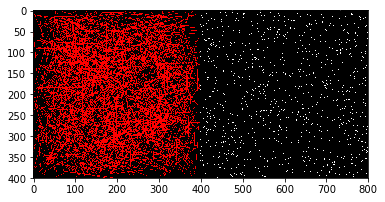

In [5]:
# INITIALIZE SIMULATION AND DOMAIN 
# J -> myosin II motor data:
#    J(0,:) = progression of myosin state
#        0-inactive
#        1-active
#        2-bundled & active
#    J(1,:) = index of motor bundled to (-1 means no bundle)
#    J(2,:) = index of filament bound to (-1 means no binding to filament)
#    J(3,:) = x position of motor head
#    J(4,:) = y position of motor head
# Z -> actin filament data:
#    Z(0,:) = x position of filament +end
#    Z(1,:) = y position of filament +end
#    Z(2,:) = angle of orientation (unit circle, CCW)
#    Z(3,:) = Z(1,:) + (fil_length * cos(Z(3,:))) x position of filament -end
#    Z(4,:) = Z(2,:) + (fil_length * sin(Z(3,:))) y position of filament -end

from PIL import Image, ImageDraw

# check if 'ims/'directory exists to store data and create directory if not
# create save path/name data
if params['save_image'] == 1 and not path.exists(params['image_save_path']):
    makedirs(params['image_save_path'])
    
# check if 'pos_data/'directory exists to store data and create directory if not
# create save path/name data
if params['save_pos_data'] == 1 and not path.exists(params['pos_save_path']):
    makedirs(params['pos_save_path'])    


# fix saved image size to match specified resolution
params['s'] = tuple([params['sx'],params['sy']])
params['s'] = np.asarray((params['s'][0]*params['res'],params['s'][1]*params['res']))

# pre-allocate memory for output arrays
J = np.zeros((5,params['motors']))
J[[1,2],:] = -1
Z = np.zeros((5,params['filaments']))

# define boundary
boundary_height = params['boundary_height'];
boundary_width = params['boundary_width'];
boundary = pltpath.Path([(-1*boundary_width,-1*boundary_height),
                      (-1*boundary_width,boundary_height),
                      (boundary_width,boundary_height),
                      (boundary_width,-1*boundary_height)],
                      readonly=True)

# initialize positions
J,Z = initialize_positions_box(params,boundary,J,Z)

# save positional information
if params['save_pos_data'] == 1:
    order = len(str(params['time']))
    lead_zeros = order - 1
    built_name = ''
    for i in range(lead_zeros):
        built_name+='0'
    jfile = './pos_data/jdata_'+built_name+'0'+'.txt'
    zfile = './pos_data/zdata_'+built_name+'0'+'.txt'
    np.savetxt(jfile, np.transpose(J))
    np.savetxt(zfile, np.transpose(Z))
    
# write initial image data to '.png' file
if params['save_image']==1:
    order = len(str(params['time']))
    lead_zeros = order - 1
    built_name = ''
    for i in range(lead_zeros):
        built_name+='0'
    name = params['image_save_path']+params['image_save_name']+built_name+'0'+'.png'
    im_png = Image.fromarray(split_image_build(J,Z,params))
    im_png.save(name)
    
    imshow(im_png)

In [6]:
# RUN THE SIMULATION 

J,Z = sim(J,Z,params,boundary)

# run simulation and view sub-routine runtime metrics
# import cProfile
# cProfile.run('sim(J,Z,params,boundary)')

100%|██████████| 500/500 [05:32<00:00,  1.52it/s]


Number of Asters Classified:  4


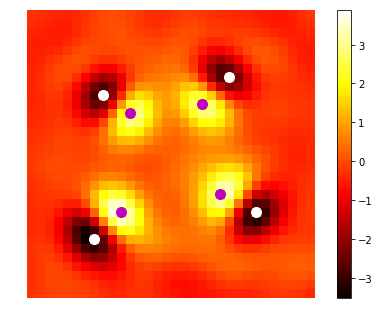

In [7]:
# COUNT ASTERS 
def count_asters(Z,params):
    '''method for analyzing filament positions in
       simulation domain and determining number of
       asters formed'''
    # set parameters
    L = params['fil_length']
    d = L/8.0
    R = 2.0
    ep = 0.001

    # calculate the number of boxes required for the given spacing
    numBoxes = int(2*R/d+2)

    # calculate the boundary paths for each box in the calculation
    boxes = {(n1,n2): pltpath.Path([((n2-1)*d-R,(n1-1)*d-R),
                                    ((n2-1)*d-R,(n1)*d-R),
                                    ((n2)*d-R,(n1)*d-R),
                                    ((n2)*d-R,(n1-1)*d-R)],
                                    readonly=True) for n1, n2 in product(range(numBoxes), range(numBoxes))}

    # calculate summed vectors for each box
    sumX = np.zeros((numBoxes,numBoxes))
    sumY = np.zeros((numBoxes,numBoxes))
    for n1 in range(numBoxes):
        for n2 in range(numBoxes):
            V = np.array((0,0))
            for i in range(Z[0,:].shape[0]):
                if boxes[(n1,n2)].contains_point(np.array([Z[0,i],Z[1,i]])):
                    V = np.array((V[0]+Z[0,i] - np.cos(Z[2,i]), V[1]+Z[1,i] - np.sin(Z[2,i])))
            sumX[n1,n2] = V[0]
            sumY[n1,n2] = V[1]

    # calculate 2nd order divergence of X and Y component vectors in each box
    divX = np.zeros((numBoxes,numBoxes))
    divY = np.zeros((numBoxes,numBoxes))
    for n1 in range(numBoxes):
        for n2 in range(numBoxes):
            if n1==0 or n2==0 or n1==numBoxes-1 or n2==numBoxes-1:
                divX[n1,n2] = 0
                divY[n1,n2] = 0
            else:
                divX[n1,n2] = (sumX[n1,n2+1]-sumX[n1,n2-1])/(2*d)
                divY[n1,n2] = (sumY[n1+1,n2]-sumY[n1-1,n2])/(2*d)

    # calculate divergence vector for each box
    divergence = np.zeros((numBoxes-2,numBoxes-2))
    for n1 in range(1,numBoxes-1):
        for n2 in range(1,numBoxes-1):
            divergence[n1-1,n2-1] = divX[n1,n2] + divY[n1,n2]
    div = divergence

    # calculate signal-to-noise ratio to use as threshold on divergence heat map
    mean_div = np.mean(div)
    stdv_div = np.std(div,ddof=1)
    SNR = mean_div/stdv_div

    div_thresh = np.zeros((numBoxes-2,numBoxes-2))
    for i in range(numBoxes-2):
        for j in range(numBoxes-2):
            if abs(div[i,j])>SNR:
                div_thresh[i,j] = div[i,j]

    # create gaussian filter array for 2D convolution and apply
    N = 10 # size of gaussian filter N x N
    sigma = 2 # sigma value of gaussian function
    x,y = np.meshgrid(np.arange(-N/2,N/2+1),np.arange(-N/2,N/2+1))
    gauss_func = np.around(np.exp(-x**2/(2*sigma**2) - y**2/(2*sigma*2)),decimals=4)
    gauss_mat = np.around(gauss_func/np.sum(gauss_func[:]),decimals=4)

    # apply gaussian filter through 2D convolution
    div_filt = convolve2d(div_thresh,gauss_mat,mode="same")

    # z-score standardization of filtered image
    div_z = (div_filt - np.mean(div_filt)) / np.std(div_filt,ddof=1)

    # aster counter algorithm
    B = div_z

    # calculate neighborhood size (L/2)
    orig_domain = 4
    new_domain = orig_domain/(L/8)
    new_L = new_domain*(L/orig_domain)
    neighborhood_size = (new_L*0.5)

    # define upper and lower bound across range of values in div_z
    maxB = np.max(div_z)
    minB = np.min(div_z)
    rangeB = maxB - minB
    ubound = 0.25*rangeB
    lbound = 0.25*rangeB
    ub = maxB - ubound
    if ub < 2.5:
        ub = 2.5
    lb = minB + lbound
    if lb > -2.5:
        lb = -2.5

    # find maximal points in absolute value of div_z
    data_max = filters.maximum_filter(div_z, neighborhood_size)
    data_min = filters.minimum_filter(div_z, neighborhood_size)
    maxima = (div_z == data_max)
    u_diff = ((data_max > ub))
    maxima[u_diff == 0] = 0

    labeled, num_objects = ndimage.label(maxima)
    slices = ndimage.find_objects(labeled)
    ux, uy = [], []
    for dy,dx in slices:
        x_center = (dx.start + dx.stop - 1)/2
        ux.append(x_center)
        y_center = (dy.start + dy.stop - 1)/2
        uy.append(y_center)

    # find minimal points in div_z
    data_max = filters.maximum_filter(div_z, neighborhood_size)
    data_min = filters.minimum_filter(div_z, neighborhood_size)
    minima = (div_z == data_min)
    l_diff = ((data_min < lb))
    minima[l_diff == 0] = 0

    labeled, num_objects = ndimage.label(minima)
    slices = ndimage.find_objects(labeled)
    lx, ly = [], []
    for dy,dx in slices:
        x_center = (dx.start + dx.stop - 1)/2
        lx.append(x_center)
        y_center = (dy.start + dy.stop - 1)/2
        ly.append(y_center)

    max_x = ux[:]
    max_y = uy[:]
    min_x = lx[:]
    min_y = ly[:]

    dist_thresh = new_L
    # check if maxima are near minima
    u_idx_rm = []
    for i in range(len(ux)):
        close_count = 0
        for j in range(len(lx)):
            dist = np.sqrt((ux[i]-lx[j])**2 + (uy[i]-ly[j])**2)
            if dist < dist_thresh:
                close_count+=1
        if close_count == 0:
            u_idx_rm.append(i)

    # check if minima are near maxima
    l_idx_rm = []
    for i in range(len(lx)):
        close_count = 0
        for j in range(len(ux)):
            dist = np.sqrt((lx[i]-ux[j])**2 + (ly[i]-uy[j])**2)
            if dist < dist_thresh:
                close_count+=1
        if close_count == 0:
            l_idx_rm.append(i)

    # remove extreme points that are not near counterpart
    for index in sorted(u_idx_rm, reverse=True):
        del max_x[index]
        del max_y[index]
    for index in sorted(l_idx_rm, reverse=True):
        del min_x[index]
        del min_y[index]

    # count asters
    number_of_asters = min(len(min_x),len(max_x))
    with open("./asters.txt", "w") as text_file:
        text_file.write(str(number_of_asters))

    sizes = np.shape(div_filt)
    height = float(sizes[0])
    width = float(sizes[1])

    fig = plt.figure()
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.add_axes(ax)

    ax.plot(ux,uy, 'mx', markersize=8)
    ax.plot(max_x,max_y, 'mo', markersize=10)
    ax.plot(lx,ly, 'wx', markersize=8)
    ax.plot(min_x,min_y, 'wo', markersize=10)
    im = ax.imshow(div_z, cmap="hot")
    fig.colorbar(im)
    plt.axis('off')

    plt.savefig('aster_plot.png', dpi = 200)

    # plt.close()

    return number_of_asters

print("Number of Asters Classified: ",count_asters(Z,params))

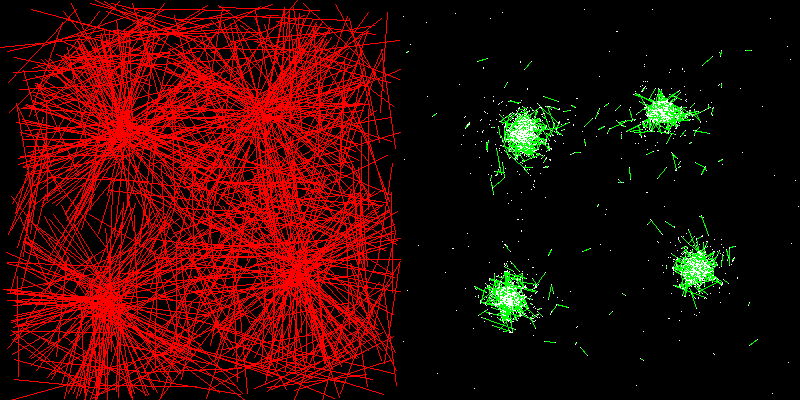

In [8]:
# VIEW IMAGES 
from ipywidgets import interact
from IPython.display import Image, display

# store image data as values and filenames as keys
def get_image(key):
    if not key in cache:
        cache[key] = open(key,'rb').read()
    return cache[key]

# display image by grabing data from dictionary
def pltimg(Time=0):
    order = len(str(params['time']))
    lead_zeros = order - len(str(Time))
    built_name = ''
    for i in range(lead_zeros):
        built_name+='0'
    filename = params['image_save_path']+'sim_'+built_name+str(Time)+'.png'
    display(Image(data=cache[filename]))

# get filenames for each image sorted and store byte data in dictionary
cache = {}
images = sorted(glob.glob(params['image_save_path']+'*.png'))
[get_image(image) for image in images]

# actively plot image as scroll bar changes value
interact(pltimg, Time=(0,params['time'],params['image_iter']))

In [9]:
# CONVERT '.PNG' IMAGES INTO A '.TIFF' STACK 
tiff_name = 'full_sim.tif'
path = './'

for idx,image_path in tqdm(enumerate(sorted(glob.glob("./ims/"+'*.png')))):
    im = misc.imread(image_path)
    if idx == 0:
        imsave(path+tiff_name,im,compress=1)
    else:
        imsave(path+tiff_name,im,append=True,compress=1)

501it [00:14, 34.66it/s]
